<a href="https://colab.research.google.com/github/n3d1m/SYDE-677-Final-Project/blob/main/LungSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lungs-segmentation

In [2]:
# Imports
import zipfile
import random
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from skimage import exposure
from sklearn import metrics
import torch

In [3]:
!rm -r sample_data/
!rm -r training_data/

!mkdir training_data


rm: cannot remove 'training_data/': No such file or directory


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Downloading: "https://github.com/alimbekovKZ/lungs_segmentation/releases/download/1.0.0/resnet34.pth" to /root/.cache/torch/hub/checkpoints/resnet34.pth


  0%|          | 0.00/98.6M [00:00<?, ?B/s]

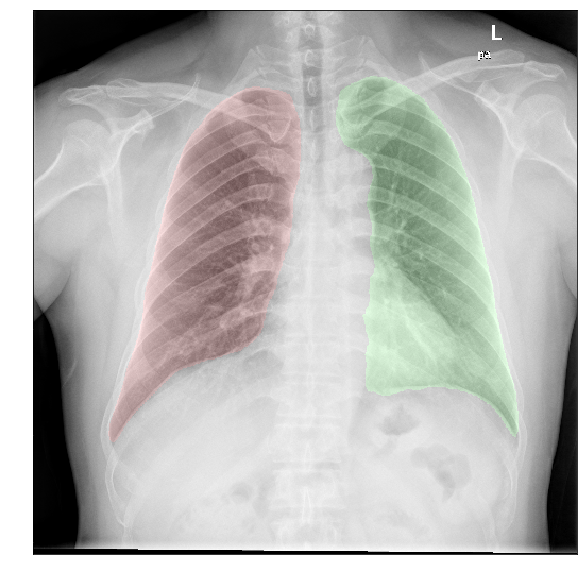

In [5]:
from lungs_segmentation.pre_trained_models import create_model
import lungs_segmentation.inference as inference

model = create_model("resnet34")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

test_image_1 = '/content/drive/MyDrive/SYDE 677 Final Project/CXR_png/CHNCXR_0001_0.png'


plt.figure(figsize=(10,10))
plt.subplot(1,1,1)
image, mask = inference.inference(model,test_image_1, 0.2)
plt.imshow(inference.img_with_masks( image, [mask[0], mask[1]], alpha = 0.1))

In [6]:
image_directory = '/content/drive/MyDrive/SYDE 677 Final Project/CXR_png/'
mask_directory = '/content/drive/MyDrive/SYDE 677 Final Project/masks/'

image_list = os.listdir(image_directory)
mask_list = os.listdir(mask_directory)

image_names = [im.split('.')[0].strip() for im in image_list]
mask_names = [msk.split('.')[0].strip() for msk in mask_list]

master_image_list = []

for i in range(len(mask_names)):

    mask = mask_names[i]

    if 'CHNCXR' in mask:
        mask = mask.split('_mask')[0]

    if mask in image_names:
        master_image_list.append(mask)

print(master_image_list)

['CHNCXR_0076_0', 'CHNCXR_0073_0', 'CHNCXR_0029_0', 'CHNCXR_0045_0', 'CHNCXR_0063_0', 'CHNCXR_0011_0', 'CHNCXR_0077_0', 'CHNCXR_0053_0', 'CHNCXR_0068_0', 'CHNCXR_0052_0', 'CHNCXR_0067_0', 'CHNCXR_0026_0', 'CHNCXR_0017_0', 'CHNCXR_0069_0', 'CHNCXR_0015_0', 'CHNCXR_0075_0', 'CHNCXR_0008_0', 'CHNCXR_0032_0', 'CHNCXR_0070_0', 'CHNCXR_0023_0', 'CHNCXR_0074_0', 'CHNCXR_0031_0', 'CHNCXR_0010_0', 'CHNCXR_0009_0', 'CHNCXR_0054_0', 'CHNCXR_0047_0', 'CHNCXR_0024_0', 'CHNCXR_0020_0', 'CHNCXR_0005_0', 'CHNCXR_0058_0', 'CHNCXR_0056_0', 'CHNCXR_0059_0', 'CHNCXR_0035_0', 'CHNCXR_0055_0', 'CHNCXR_0019_0', 'CHNCXR_0016_0', 'CHNCXR_0051_0', 'CHNCXR_0072_0', 'CHNCXR_0027_0', 'CHNCXR_0028_0', 'CHNCXR_0007_0', 'CHNCXR_0018_0', 'CHNCXR_0012_0', 'CHNCXR_0002_0', 'CHNCXR_0050_0', 'CHNCXR_0013_0', 'CHNCXR_0030_0', 'CHNCXR_0004_0', 'CHNCXR_0021_0', 'CHNCXR_0057_0', 'CHNCXR_0043_0', 'CHNCXR_0078_0', 'CHNCXR_0014_0', 'CHNCXR_0006_0', 'CHNCXR_0022_0', 'CHNCXR_0003_0', 'CHNCXR_0044_0', 'CHNCXR_0061_0', 'CHNCXR_0033_

In [7]:
def generate_full_mask(dim,mask):

  vis = np.zeros(dim, np.uint8)

  full_mask = vis + mask[0] + mask[1]

  return full_mask



In [8]:
def resize_mask(mask,dim):

  to_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
  resized = cv2.resize(to_gray, dim, interpolation = cv2.INTER_AREA)

  return resized


In [9]:
def dice(pred, true, k = 1):

    pred = cv2.normalize(pred, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    true = cv2.normalize(true, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    intersection = np.sum(pred[true==k]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

In [16]:
def jaccard(pred,true):

  # pred = cv2.normalize(pred, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  # true = cv2.normalize(true, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

  jaccard = metrics.jaccard_score(np.array(true).flatten(), np.array(pred).flatten(),average=None)

  return jaccard.max()


In [11]:
def analyze_masks(image_directory, mask_directory, file_list):

  dice_array = []
  jaccard_array = []

  for i in tqdm(range(len(file_list))):

    if (file_list[i] != 'Thumbs.db'):

      
      img = image_directory + file_list[i] + '.png'
      mask_name = file_list[i] + '_mask.png' if 'CHNCXR' in file_list[i] else file_list[i] + '.png'
      mask = cv2.imread(mask_directory + mask_name)

      model_image, model_mask = inference.inference(model,img, 0.2)
      image_shape = model_image.shape
      dimensions = [image_shape[0], image_shape[1]]

      mask = resize_mask(mask,dimensions)
      model_mask = generate_full_mask(dimensions, model_mask)

      dice_score = dice(model_mask,mask)
      jaccard_score = jaccard(model_mask,mask)

      dice_array.append(dice_score)
      jaccard_array.append(jaccard_score)

      
  
  
  return[dice_array,jaccard_array]
  


In [15]:
image, mask = inference.inference(model,test_image_1, 0.2)

test_mask_path = '/content/drive/MyDrive/SYDE 677 Final Project/masks/CHNCXR_0001_0_mask.png'
test_mask = cv2.imread(test_mask_path)

image_shape = image.shape
dimensions = [image_shape[0], image_shape[1]]

test_mask = resize_mask(test_mask,dimensions)
model_mask = generate_full_mask(dimensions, mask)

# plt.figure()
# plt.imshow(test_mask,cmap='Greys_r')

# plt.figure()
# plt.imshow(model_mask,cmap='Greys_r')

dice_score = dice(model_mask,test_mask)
jaccard_score = jaccard(model_mask,test_mask)

print(dice_score)
print(jaccard_score[1])

0.9605900953292136
0.00011162316021112724


In [17]:
metric_scores = analyze_masks(image_directory,mask_directory,master_image_list)



100%|██████████| 704/704 [26:01<00:00,  2.22s/it]


In [19]:
print('Dice: ', np.mean(metric_scores[0]),np.std(metric_scores[0]))
print('Jaccard: ', np.mean(metric_scores[1]),np.std(metric_scores[1]))

Dice:  0.9512200868948166 0.04103703297489042
Jaccard:  0.9796839031367774 0.01156206379394255


In [20]:
def unzip_images(zip_location, extraction_location):
  with zipfile.ZipFile(zip_location, 'r') as zip_ref:
    zip_ref.extractall(extraction_location)

In [21]:
unzip_images('/content/drive/MyDrive/SYDE 677 Final Project/all_data.zip','/content/training_data')

In [22]:
metric_scores = analyze_masks('/content/training_data/all_data/images/','/content/training_data/all_data/masks/',master_image_list)

100%|██████████| 704/704 [07:28<00:00,  1.57it/s]


In [23]:
print('Dice: ', np.mean(metric_scores[0]),np.std(metric_scores[0]))
print('Jaccard: ', np.mean(metric_scores[1]),np.std(metric_scores[1]))

Dice:  0.9442110307621739 0.05527889057142691
Jaccard:  0.9742744228720888 0.01554802445749408


In [24]:
!mkdir set_1_normalized
!mkdir set_2_normalized
!mkdir set_3_normalized

In [25]:
def normalization(image_path, save_path):
    list_of_files = os.listdir(image_path)
    for i in tqdm(range(len(list_of_files))):
        img = cv2.imread(image_path + list_of_files[i])
        img = exposure.equalize_adapthist(img / np.max(img))
        img = exposure.rescale_intensity(img, out_range=(0, 255))

        cv2.imwrite(save_path + list_of_files[i], img)

In [27]:
normalization('/content/drive/MyDrive/SYDE 677 Final Project/drive_images_1/','/content/set_1_normalized/')
normalization('/content/drive/MyDrive/SYDE 677 Final Project/drive_images_2/','/content/set_2_normalized/')
normalization('/content/drive/MyDrive/SYDE 677 Final Project/drive_images_3/','/content/set_3_normalized/')

100%|██████████| 100/100 [01:44<00:00,  1.05s/it]


In [33]:
def analyze_other(original_directory, normalization_directory):

  dice_array = []
  jaccard_array = []

  file_list = os.listdir(original_directory)

  for i in tqdm(range(len(file_list))):

    if (file_list[i] != 'Thumbs.db'):
      
      original_img = original_directory + file_list[i] 
      normalized_img = normalization_directory + file_list[i] 

      original_image, original_mask = inference.inference(model,original_img, 0.2)
      normalized_image, normalized_mask = inference.inference(model,normalized_img, 0.2)

      image_shape = original_image.shape
      dimensions = [image_shape[0], image_shape[1]]

      original_mask = generate_full_mask(dimensions, original_mask)
      normalized_mask = generate_full_mask(dimensions, normalized_mask)

      dice_score = dice(original_mask,normalized_mask)
      jaccard_score = jaccard(original_mask,normalized_mask)

      dice_array.append(dice_score)
      jaccard_array.append(jaccard_score)

      
  
  
  return[dice_array,jaccard_array]

In [47]:
metric_scores = analyze_other('/content/drive/MyDrive/SYDE 677 Final Project/drive_images_1/','/content/set_1_normalized/')

100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


Dice:  0.8985449015592741 0.2650150937751705
Jaccard:  0.9820728530360302 0.01364373161673959


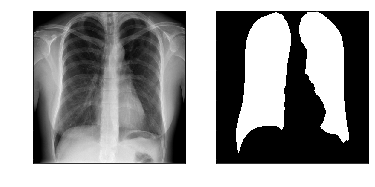

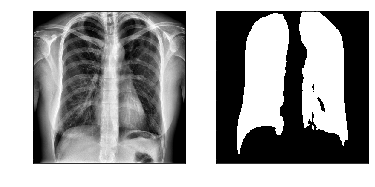

In [52]:
print('Dice: ', np.mean(metric_scores[0]),np.std(metric_scores[0]))
print('Jaccard: ', np.mean(metric_scores[1]),np.std(metric_scores[1]))

min_value_dice = min(metric_scores[1])
min_index_dice = metric_scores[1].index(min_value_dice)

image_directory = os.listdir('/content/drive/MyDrive/SYDE 677 Final Project/drive_images_1/')

original_img = '/content/drive/MyDrive/SYDE 677 Final Project/drive_images_1/' + image_directory[min_index_dice]
normalized_img = '/content/set_1_normalized/' + image_directory[min_index_dice]

original_image, original_mask = inference.inference(model,original_img, 0.2)
normalized_image, normalized_mask = inference.inference(model,normalized_img, 0.2)

image_shape = original_image.shape
dimensions = [image_shape[0], image_shape[1]]

original_mask = generate_full_mask(dimensions, original_mask)
normalized_mask = generate_full_mask(dimensions, normalized_mask)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(original_image)
ax2.imshow(original_mask,cmap='Greys_r')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(normalized_image)
ax2.imshow(normalized_mask,cmap='Greys_r')

In [37]:
metric_scores = analyze_other('/content/drive/MyDrive/SYDE 677 Final Project/drive_images_2/','/content/set_2_normalized/')
print('Dice: ', np.mean(metric_scores[0]),np.std(metric_scores[0]))
print('Jaccard: ', np.mean(metric_scores[1]),np.std(metric_scores[1]))

100%|██████████| 100/100 [00:42<00:00,  2.36it/s]

Dice:  0.9488018770272951 0.1704212554700031
Jaccard:  0.9816241253767721 0.012766537541781559


In [38]:
metric_scores = analyze_other('/content/drive/MyDrive/SYDE 677 Final Project/drive_images_3/','/content/set_3_normalized/')
print('Dice: ', np.mean(metric_scores[0]),np.std(metric_scores[0]))
print('Jaccard: ', np.mean(metric_scores[1]),np.std(metric_scores[1]))

100%|██████████| 100/100 [00:20<00:00,  4.94it/s]

Dice:  0.9563384106830317 0.14068057683191834
Jaccard:  0.9821353554381179 0.013545519807760004


0.9815798862121411 0.983981930005987


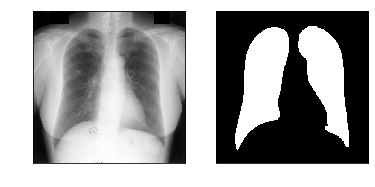

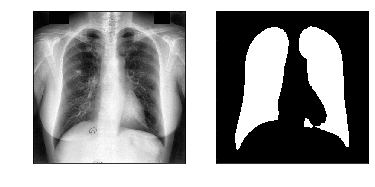

In [63]:


original_img = '/content/drive/MyDrive/SYDE 677 Final Project/drive_images_2/JPCLN004.png'
normalized_img = '/content/set_2_normalized/JPCLN004.png'

original_image, original_mask = inference.inference(model,original_img, 0.2)
normalized_image, normalized_mask = inference.inference(model,normalized_img, 0.2)

image_shape = original_image.shape
dimensions = [image_shape[0], image_shape[1]]

original_mask = generate_full_mask(dimensions, original_mask)
normalized_mask = generate_full_mask(dimensions, normalized_mask)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(original_image)
ax2.imshow(original_mask,cmap='Greys_r')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(normalized_image)
ax2.imshow(normalized_mask,cmap='Greys_r')

dice_score = dice(original_mask,normalized_mask)
jaccard_score = jaccard(original_mask,normalized_mask)

print(dice_score, jaccard_score)

0.9932781194336459 0.9944333182591468


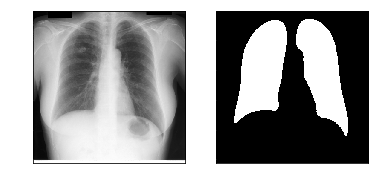

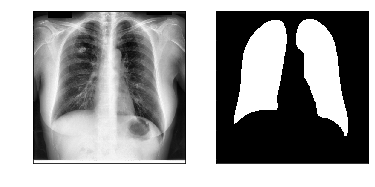

In [65]:
original_img = '/content/drive/MyDrive/SYDE 677 Final Project/drive_images_2/JPCLN006.png'
normalized_img = '/content/set_2_normalized/JPCLN006.png'

original_image, original_mask = inference.inference(model,original_img, 0.2)
normalized_image, normalized_mask = inference.inference(model,normalized_img, 0.2)

image_shape = original_image.shape
dimensions = [image_shape[0], image_shape[1]]

original_mask = generate_full_mask(dimensions, original_mask)
normalized_mask = generate_full_mask(dimensions, normalized_mask)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(original_image)
ax2.imshow(original_mask,cmap='Greys_r')

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(normalized_image)
ax2.imshow(normalized_mask,cmap='Greys_r')

dice_score = dice(original_mask,normalized_mask)
jaccard_score = jaccard(original_mask,normalized_mask)

print(dice_score, jaccard_score)